# Assignment 1: Web Scraping

<p color=red>I have structurally adjusted all the code and open sourced it to the Github repository, and attached a detailed README file. You can view details from the repository and get complete code, csv files, and visualizations.This notebook is just a simple copy.</p>

<p> The default visualization contains some data that is not filtered. For detailed data cleaning and filtering, please view the Github repo.</p>

Github repo: https://github.com/siruzhong/HKUST-GZ-Faculty-EDA

## Objective

Data scientists often need to crawl data from websites and turn the crawled data (HTML pages) to structured data (tables). Thus, web scraping is an essential skill that every data scientist should master. In this assignment, you will learn the followings:


* How to download HTML pages from a website?
* How to extract relevant content from an HTML page? 

Furthermore, you will gain a deeper understanding of the data science lifecycle.

**Requirements:**

1. Please use [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) rather than spark.DataFrame to manipulate data.

2. Please use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) rather than [lxml](http://lxml.de/) to parse an HTML page and extract data from the page.

3. Please follow the python code style (https://www.python.org/dev/peps/pep-0008/). If TA finds your code hard to read, you will lose points. This requirement will stay for the whole semester.

## Preliminary

If this is your first time to write a web scraper, you need to learn some basic knowledge of this topic. I found that this is a good resource: [Tutorial: Web Scraping and BeautifulSoup](https://realpython.com/beautiful-soup-web-scraper-python/). 

Please let me know if you find a better resource. I'll share it with the other students.

## Overview

Imagine you are a data scientist working at HKUST(GZ). Your job is to extract insights from HKUST(GZ) data to answer questions. 

In this assignment, you will do two tasks. Please recall the high-level data science lifecycle from Lecture 1. I suggest that when doing this assignment, please remind yourself of what data you collected and what questions you tried to answer.

## Task 1: HKUST(GZ) Information Hub Faculty Members

Sometimes you don't know what questions to ask. No worries. Start collecting data first. 

In Task 1, your job is to write a web scraper to extract the faculty information from this page: [https://facultyprofiles.hkust-gz.edu.cn/](https://facultyprofiles.hkust-gz.edu.cn/).




### (a) Crawl Web Page

A web page is essentially a file stored in a remote machine (called web server). Please write code to download the HTML page and save it as a text file ("infhfaculty.html").

In [4]:
def download_html_using_selenium(url):
    """
    Downloads the HTML content using Selenium.
    Returns the HTML content and the browser instance.
    """
    browser = webdriver.Chrome()
    browser.get(url)
    time.sleep(1)  # Give some time for the page to load
    html_content = browser.page_source
    with open("infhfaculty.html", "w", encoding="utf-8") as file:
        file.write(html_content)
    browser.close()


# 使用示例
BASE_URL = 'https://facultyprofiles.hkust-gz.edu.cn/'
download_html_using_selenium(BASE_URL)

### (b) Extract Structured Data

Please write code to extract relevant content (name, rank, area, profile, homepage, ...) from "infhfaculty.html" and save them as a CSV file (save as "faculty_table.csv"). 

In [9]:
import time

from bs4 import BeautifulSoup
from loguru import logger
from selenium import webdriver
from selenium.webdriver.common.by import By


def download_html_using_selenium(url):
    """
    Downloads the HTML content using Selenium.
    Returns the HTML content and the browser instance.
    """
    browser = webdriver.Chrome()
    browser.get(url)
    time.sleep(1)  # Give some time for the page to load
    html_content = browser.page_source
    return html_content, browser


# Downloading an HTML page using existed Selenium
def download_html_using_existed_selenium(browser, url):
    browser.get(url)
    time.sleep(1)  # Allow the content to load
    return browser.page_source


def extract_teachers_data_from_html():
    """
    Extracts information about all teachers from the base faculty URL.
    """
    html_content, browser = download_html_using_selenium(BASE_URL)
    soup = BeautifulSoup(html_content, 'html.parser')
    rows = soup.select('.el-table__row')

    faculty_table = []
    faculty_grad_year = []

    for idx, row in enumerate(rows):
        # get basic information about teachers
        english_name = row.select_one('.el-table_1_column_1 .word-adjuest').text
        chinese_name = row.select_one('.el-table_1_column_2 .word-adjuest').text
        title = row.select_one('.el-table_1_column_3 .word-adjuest').text
        thrust = row.select_one('.el-table_1_column_4 .word-adjuest').text
        email = row.select_one('.el-table_1_column_5 .email-text').text

        location, homepage, overview, research_interests, degree, graduate_year = '', '', '', '', '', ''
        # Click more button
        more_buttons = browser.find_elements(By.CSS_SELECTOR, '.el-button.el-button--text.more-btn')
        if more_buttons and len(more_buttons) > idx:
            more_buttons[idx].click()
            browser.switch_to.window(browser.window_handles[1])
            more_link = browser.current_url
            # get detailed information about teachers
            email, location, homepage, overview, research_interests, degree, graduate_year = \
                extract_teacher_info_from_html(browser, more_link)
            # Close and switch back to main window
            browser.close()
            browser.switch_to.window(browser.window_handles[0])
        else:
            more_link = "Not Found"

        current_faculty = {
            'English Name': english_name,
            'Chinese Name': chinese_name,
            'Title': title,
            'Thrust/Department/Division': thrust,
            'Email': email,
            'Location': location,
            'Overview': overview,
            "Research Interest": research_interests,
            'Homepage': homepage,
            'More': more_link,
        }
        faculty_table.append(current_faculty)
        logger.info(current_faculty)

        if graduate_year != '':
            current_faculty_graduate_info = {
                'English Name': english_name,
                'Chinese Name': chinese_name,
                'Graduate Year': graduate_year,
                'Estimated age': 2023 + 23 - graduate_year,
            }
            faculty_grad_year.append(current_faculty_graduate_info)
            logger.info(current_faculty_graduate_info)

    browser.close()

    save_data_to_csv(faculty_table, faculty_grad_year)


def extract_teacher_info_from_html(browser, url):
    """
    Extract detailed information about a specific teacher.
    """
    html_content = download_html_using_existed_selenium(browser, url)
    soup = BeautifulSoup(html_content, 'html.parser')

    email, location, homepage = '', '', ''
    overview, research_interests, degree = '', [], []
    graduate_year = 0

    # Extract email, location, and homepage using direct selectors
    icon_texts = soup.select('.card-object-wrap .icon-text')
    if icon_texts:
        email = icon_texts[0].get_text() if len(icon_texts) > 0 else ''
        location = icon_texts[1].get_text() if len(icon_texts) > 1 else ''
        homepage = icon_texts[2]['href'] if 'href' in icon_texts[2].attrs else ''

    # Extract degree details
    degree_details = soup.select('.degree-detail p')
    for degree_detail in degree_details:
        degree_text = degree_detail.get_text()
        degree.append(degree_text)
        if ',' in degree_text:
            graduate_year_str = degree_text.split(',')[-1].strip()
            graduate_year = int(graduate_year_str) if graduate_year_str.isdigit() else 0

    # Extract overview
    overview_div = soup.select_one('.overview-div')
    if overview_div:
        overview = overview_div.get_text().strip()

    # Extract research interests
    tabs = soup.select('.el-tabs__nav.is-top.is-stretch .el-tabs__item.is-top')
    if tabs:
        research_interest_id = f'tab-{len(tabs) - 1}'
        browser.find_element(by=webdriver.common.by.By.ID, value=research_interest_id).click()
        time.sleep(1)  # Give some time for the new content to load
        updated_soup = BeautifulSoup(browser.page_source, 'html.parser')
        research_interest_div = updated_soup.select_one('div.overview-div[data-v-150f67ee]')
        if research_interest_div:
            research_interests = [p.get_text() for p in research_interest_div.select('p.content')]

    return email, location, homepage, overview, research_interests, degree, graduate_year


def save_data_to_csv(faculty_table, faculty_grad_year):
    """
    Saves the faculty data to CSV files.
    """
    faculty_table_df = pd.DataFrame(faculty_table)
    faculty_grad_year_df = pd.DataFrame(faculty_grad_year)

    logger.info("Saving faculty_table to faculty_table.csv")
    faculty_table_df.to_csv('faculty_table.csv', index=False)

    logger.info("Saving faculty_grad_year to faculty_grad_year.csv")
    faculty_grad_year_df.to_csv('faculty_grad_year.csv', index=False)


extract_teachers_data_from_html()

2023-09-17 11:03:14.860 | INFO     | __main__:extract_teachers_data_from_html:76 - {'English Name': 'Lei CHEN', 'Chinese Name': '陈雷', 'Title': 'Chair Professor', 'Thrust/Department/Division': 'Thrust of Data Science and Analytics', 'Email': 'leichen@hkust-gz.edu.cn', 'Location': 'E3 L5 511', 'Overview': 'Lei Chen received his BS degree in Computer Science at Tian Jin University ,P.R.China(BS 94), and an MA degree in computer science at Asian Institute of Technology (AIT) Asian Institute of Technology (MS 97). He received a Ph.D. degree in Computer Science at University of Waterloo. Lei Chen is an IEEE Fellow and ACM Distinguished Scientist.', 'Research Interest': ['Data-driven machine learning', 'Crowdsourcing-based data processing', 'Uncertain and probabilistic databases', 'Web information management', 'Multimedia systems'], 'Homepage': 'https://facultyprofiles.ust.hk/profiles.php?profile=lei-chen-leichen', 'More': 'https://facultyprofiles.hkust-gz.edu.cn/faculty-personal-page/CHEN-Le

### (c) Interesting Finding

Note that you don't need to do anything for Task 1(c). The purpose of this part is to give you some sense about how to leverage Exploratory Data Analysis (EDA) to come up with interesting questions about the data. EDA is an important topic in data science; you will  learn it soon from this course. 


First, please install [dataprep](http://dataprep.ai).
Then, run the cell below. 
It shows a bar chart for every column. What interesting findings can you get from these visualizations? 

  0%|          | 0/285 [00:00<?, ?it/s]


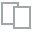
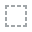
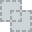
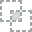
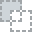
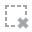
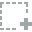
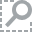
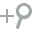
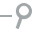
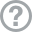
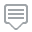
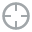
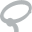
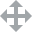
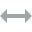
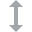
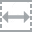
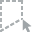
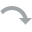
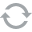
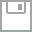
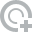
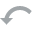
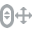
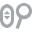
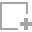
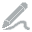
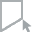
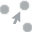
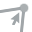
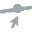

In [17]:
from dataprep.eda import plot
import pandas as pd

df = pd.read_csv("faculty_table.csv")
plot(df)

Below are some examples:

**Finding 1:** Assistant Professor# (~76) is more than 5x larger than Associate Professor# (10). 

**Questions:** Why did it happen? Is it common in all CS schools in the world? Will the gap go larger or smaller in five years? What actions can be taken to enlarge/shrink the gap?
> Why did it happen?
> - It might be due to the university's hiring strategy, which could prioritize hiring younger or early-career faculty members.
> - There might be a higher turnover rate among Associate Professors, either due to promotions, retirements, or moves to other institutions.
> - The university might have recently expanded its programs, leading to an influx of new Assistant Professors.

> Is it common in all CS schools in the world?
> - The distribution of faculty titles can vary across institutions. Some schools might have a higher number of senior faculty due to their reputation or history, while others might have more junior faculty due to recent expansion or a different hiring strategy. A comparative study across multiple CS schools would be needed to answer this definitively.

> Will the gap go larger or smaller in five years?
> - This depends on several factors, including the university's hiring and promotion strategies. If the current Assistant Professors get promoted to Associate Professors and the hiring rate remains steady, the gap might shrink. Conversely, if the university continues to hire more Assistant Professors at a higher rate, the gap could increase.

> What actions can be taken to enlarge/shrink the gap?
> - To enlarge the gap: Continue hiring at the Assistant Professor level while slowing down promotions or hiring at the Associate level.
> - To shrink the gap: Promote current Assistant Professors to Associate Professor positions and/or hire more faculty directly at the Associate Professor level.

**Finding 2:** The Homepage has 22% missing values. 

**Questions:** Why are there so many missing values? Is it because many faculty do not have their own homepages or do not add their homepages to the school page? What actions can be taken to avoid this to happen in the future?

> Why are there so many missing values?
> - Some faculty members might not have personal homepages.
> - Some faculty members might have personal homepages but haven't provided the URLs to the university.
> - There could have been errors or oversights during data collection or entry.

> Is it because many faculty do not have their own homepages or do not add their homepages to the school page?
> - It's possible. Some faculty might not see the need for personal homepages, especially if their publications and research can be easily found on other platforms or databases. Others might have homepages but didn't provide the information to the school.

> What actions can be taken to avoid this to happen in the future?
> - Encourage faculty members to create personal homepages to increase their visibility in the academic community.
> - Regularly update the faculty database and request faculty members to provide or update their homepage URLs.
> - Implement data validation checks to ensure that all new faculty entries include homepage information, if available. 

## Task 2: Age Follows Normal Distribution?

In this task, you start with a question and then figure out what data to collect.

The question that you are interested in is `Does HKUST(GZ) Info Hub faculty age follow a normal distribution?`

To estimate the age of a faculty member, you can collect the year in which s/he graduates from a university (`gradyear`) and then estimate `age` using the following equation:

$$age \approx 2023+23 - gradyear$$

For example, if one graduates from a university in 1990, then the age is estimated as 2023+23-1990 = 56. 



### (a) Crawl Web Page

You notice that faculty profile pages contain graduation information. For example, you can see that Dr. Yuyu LUO graduated from Tsinghua University in 2023 at [https://facultyprofiles.hkust-gz.edu.cn/faculty-personal-page/LUO-Yuyu/yuyuluo](https://facultyprofiles.hkust-gz.edu.cn/faculty-personal-page/LUO-Yuyu/yuyuluo). 


Please write code to download the profile pages (info hub faculties) and save each page as a text file. 

In [13]:
# Already done in Task 1:extract_teacher_info_from_html method


### (b) Extract Structured Data

Please write code to extract the earliest graduation year (e.g., 2023 for Dr. Yuyu LUO) from each profile page, and create a csv file like [faculty_grad_year.csv](./faculty_grad_year.csv). 

In [14]:
# Already done in Task 1:extract_teacher_info_from_html method

### (c) Interesting Finding

Similar to Task 1(c), you don't need to do anything here. Just look at different visualizations w.r.t. age and give yourself an answer to the question: `Does HKUST(GZ) Info Hub faculty age follow a normal distribution?`

> No, the age distribution is concentrated in the middle.

  0%|          | 0/123 [00:00<?, ?it/s]


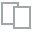
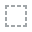
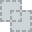
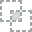
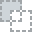
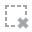
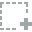
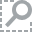
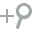
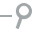
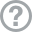
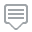
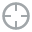
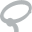
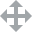
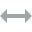
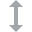
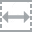
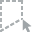
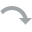
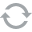
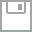
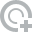
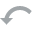
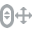
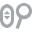
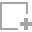
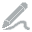
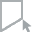
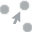
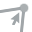
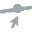

In [15]:
from dataprep.eda import plot
import pandas as pd

df = pd.read_csv("faculty_grad_year.csv")
df["age"] = 2023 + 23 - df["Graduate Year"]

plot(df, "age")


## Additional visualization

In the data exploratory analysis (EDA) process, the following visualizations were generated to gain insights into the faculty data:

1、Faculty Titles Distribution:
- Left: Horizontal bar chart showing the distribution of faculty titles.
- Right: Donut chart displaying the proportion of different titles among faculty members.

2、Research Interests Distribution:
- Includes a bar chart for the top 10 research interests and a pie chart for the top 6 research interests.
- The bar chart displays the distribution of research interests in terms of quantity.
- The pie chart shows the percentage distribution of the top 6 research interests.

3、Faculty Ages Distribution:
- Histograms for graduate years and estimated ages are displayed side by side.
- The graduate year histogram shows the distribution of faculty graduation years.
- The estimated age KDE (Kernel Density Estimation) plot shows the distribution of estimated ages, including mean and median lines.

4、Department and Title Distribution:
- Left: Horizontal bar chart displaying department distribution.
- Right: Grouped bar chart illustrating the distribution of titles within departments.

5、Word Clouds for Research Interests and Faculty Overviews:
- Word clouds representing common words in faculty research interests and overviews are displayed.

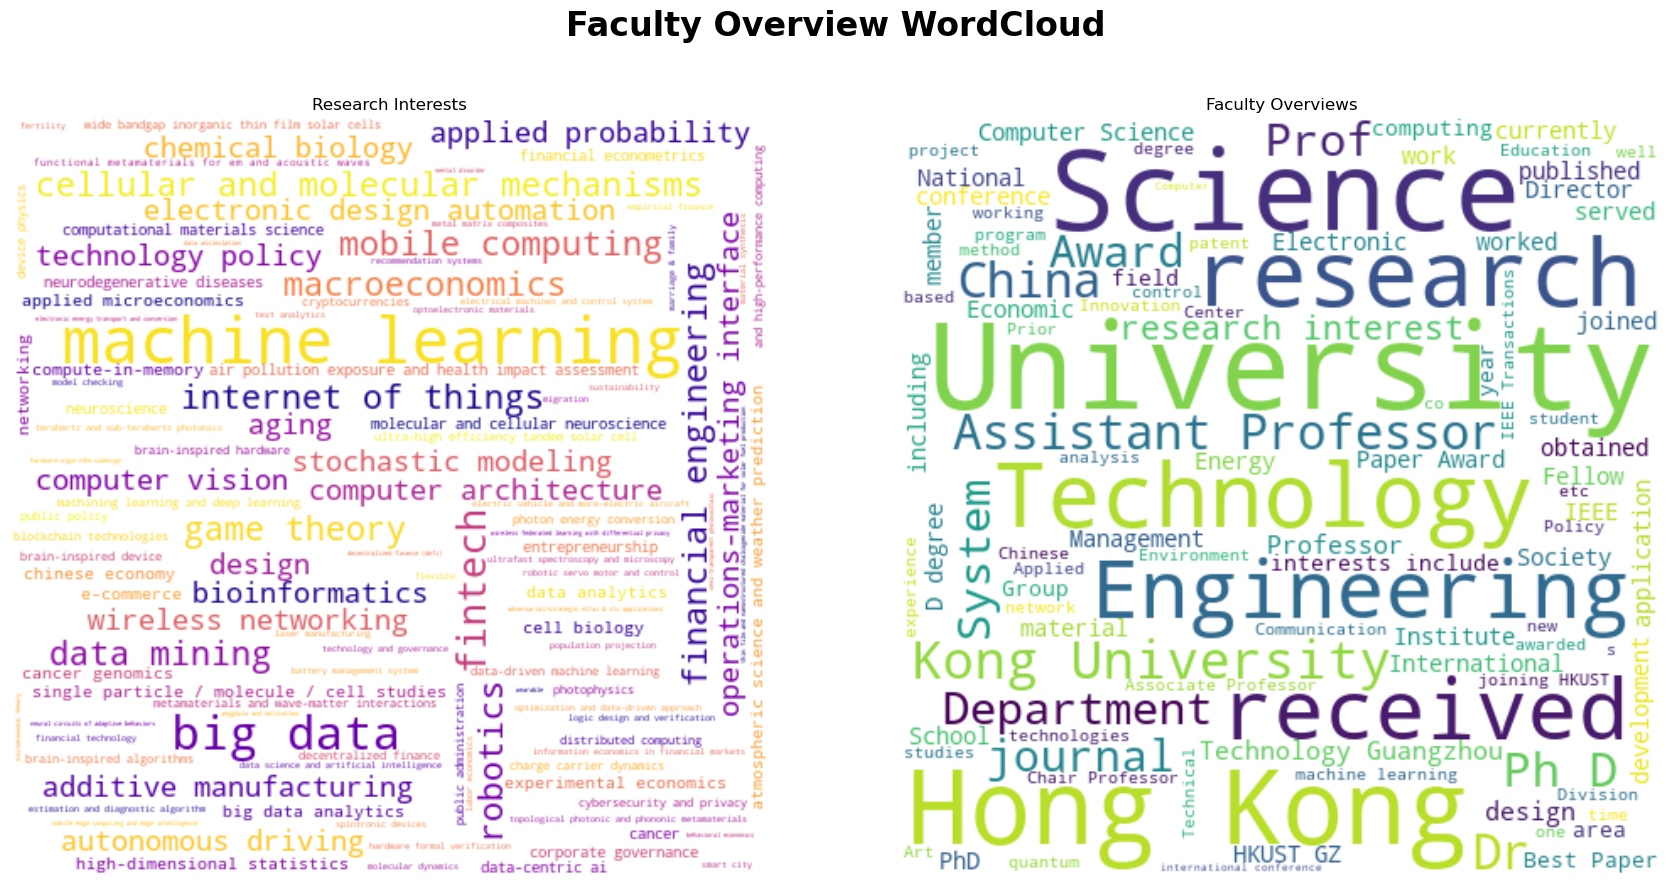

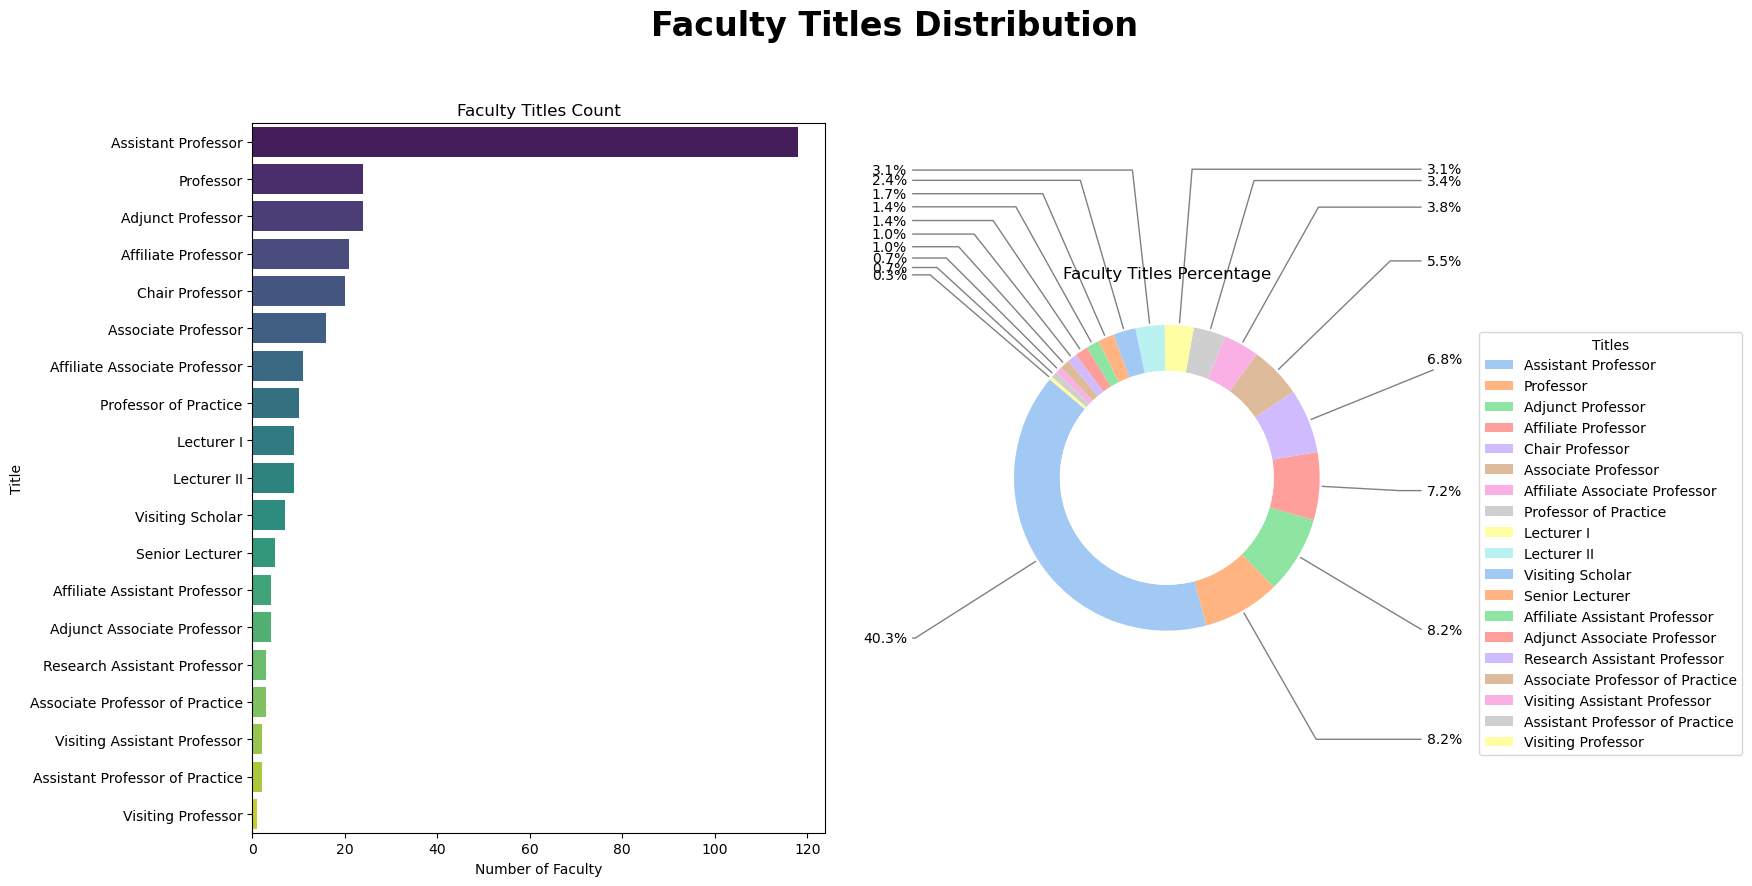

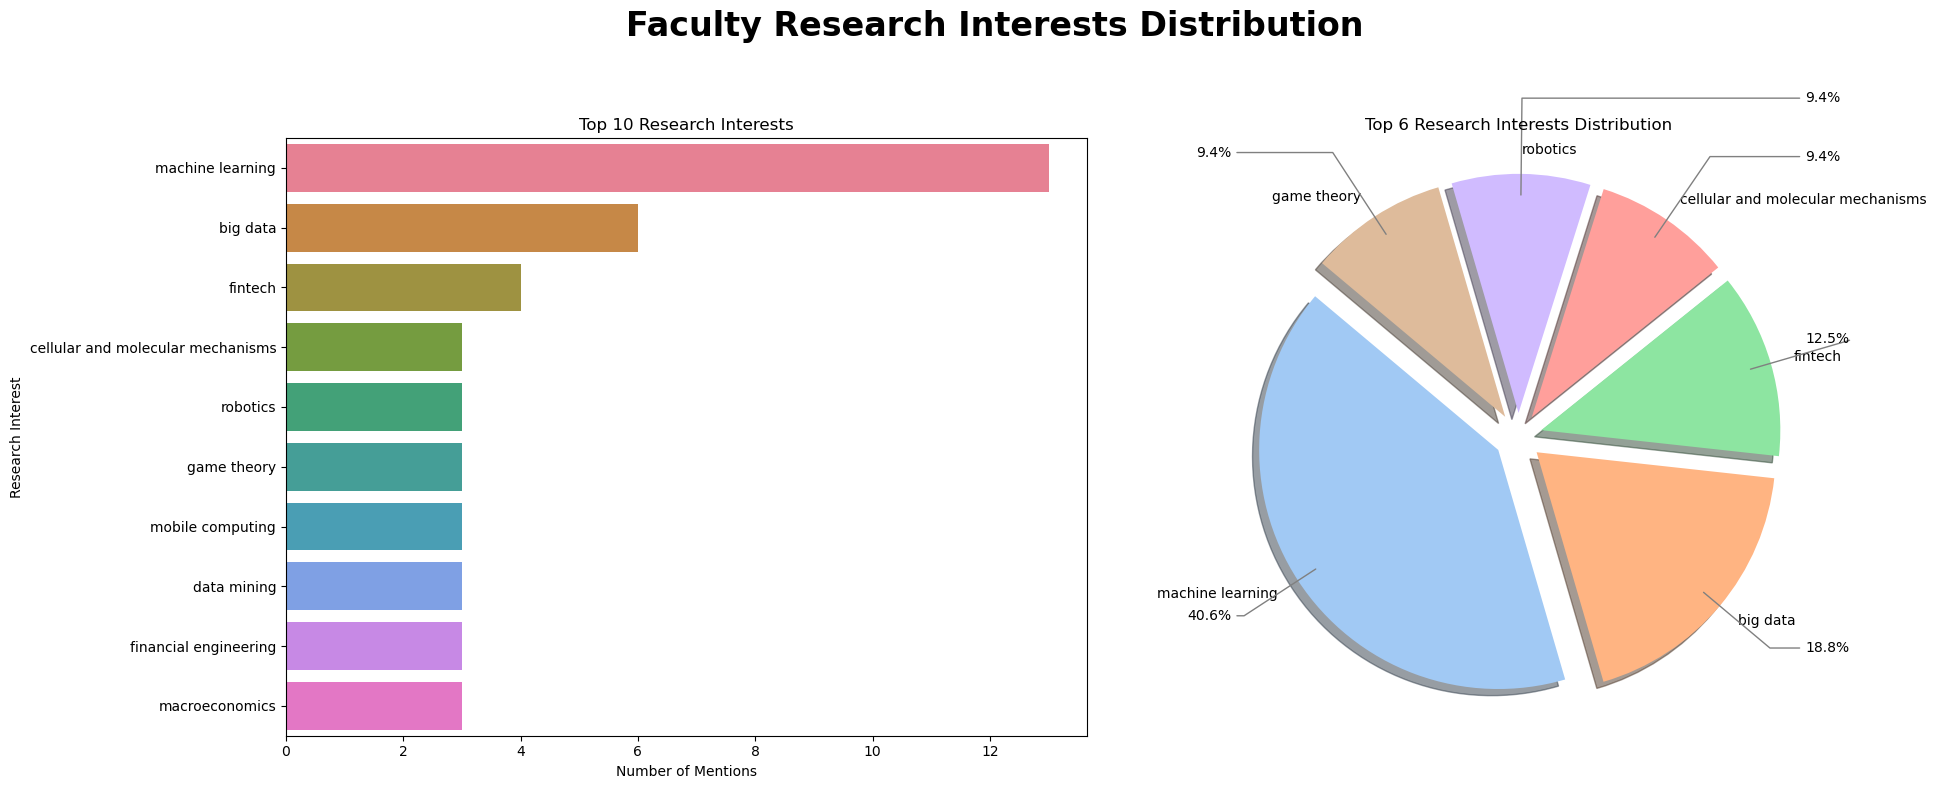

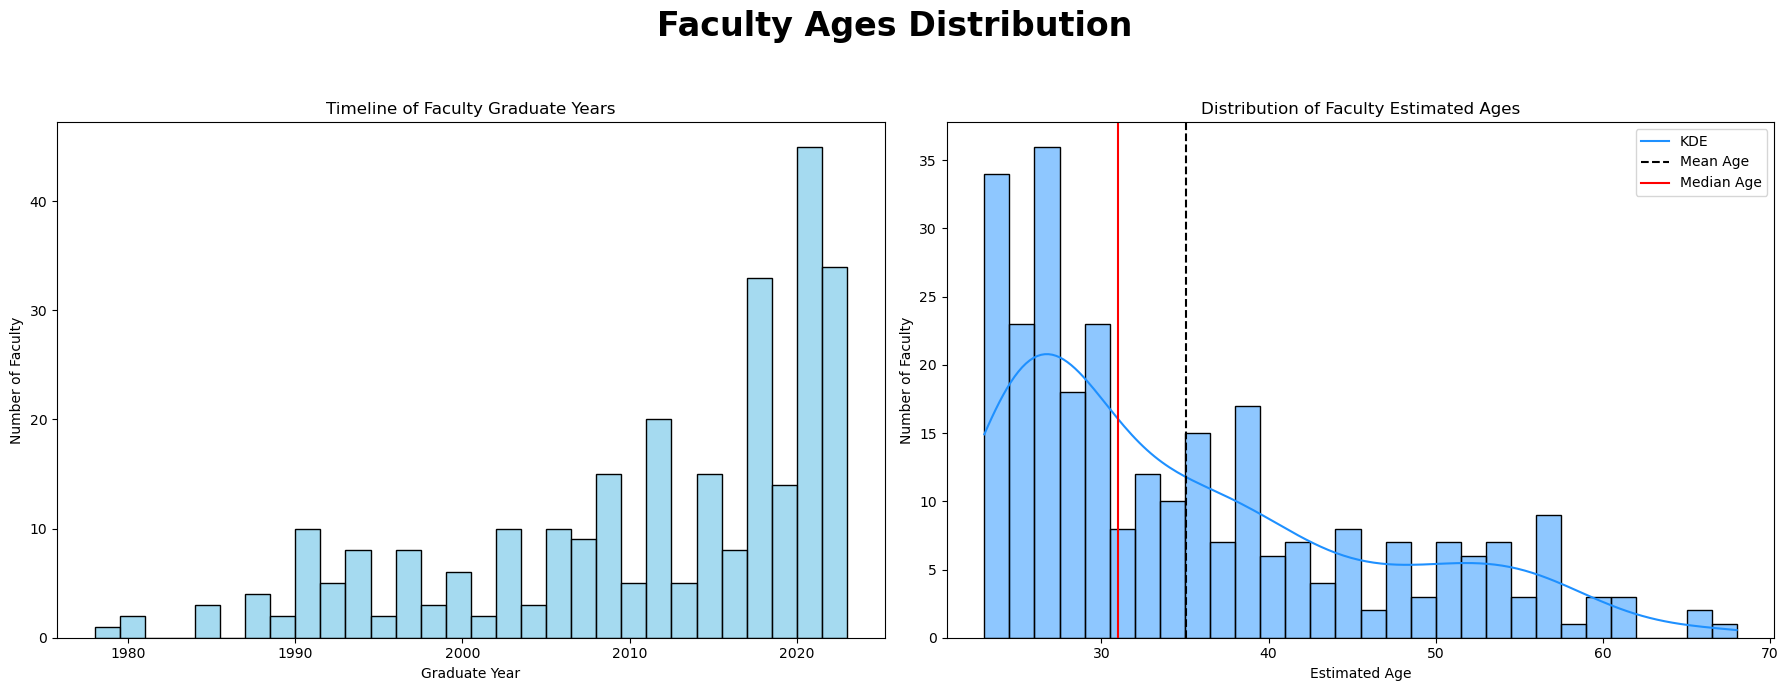

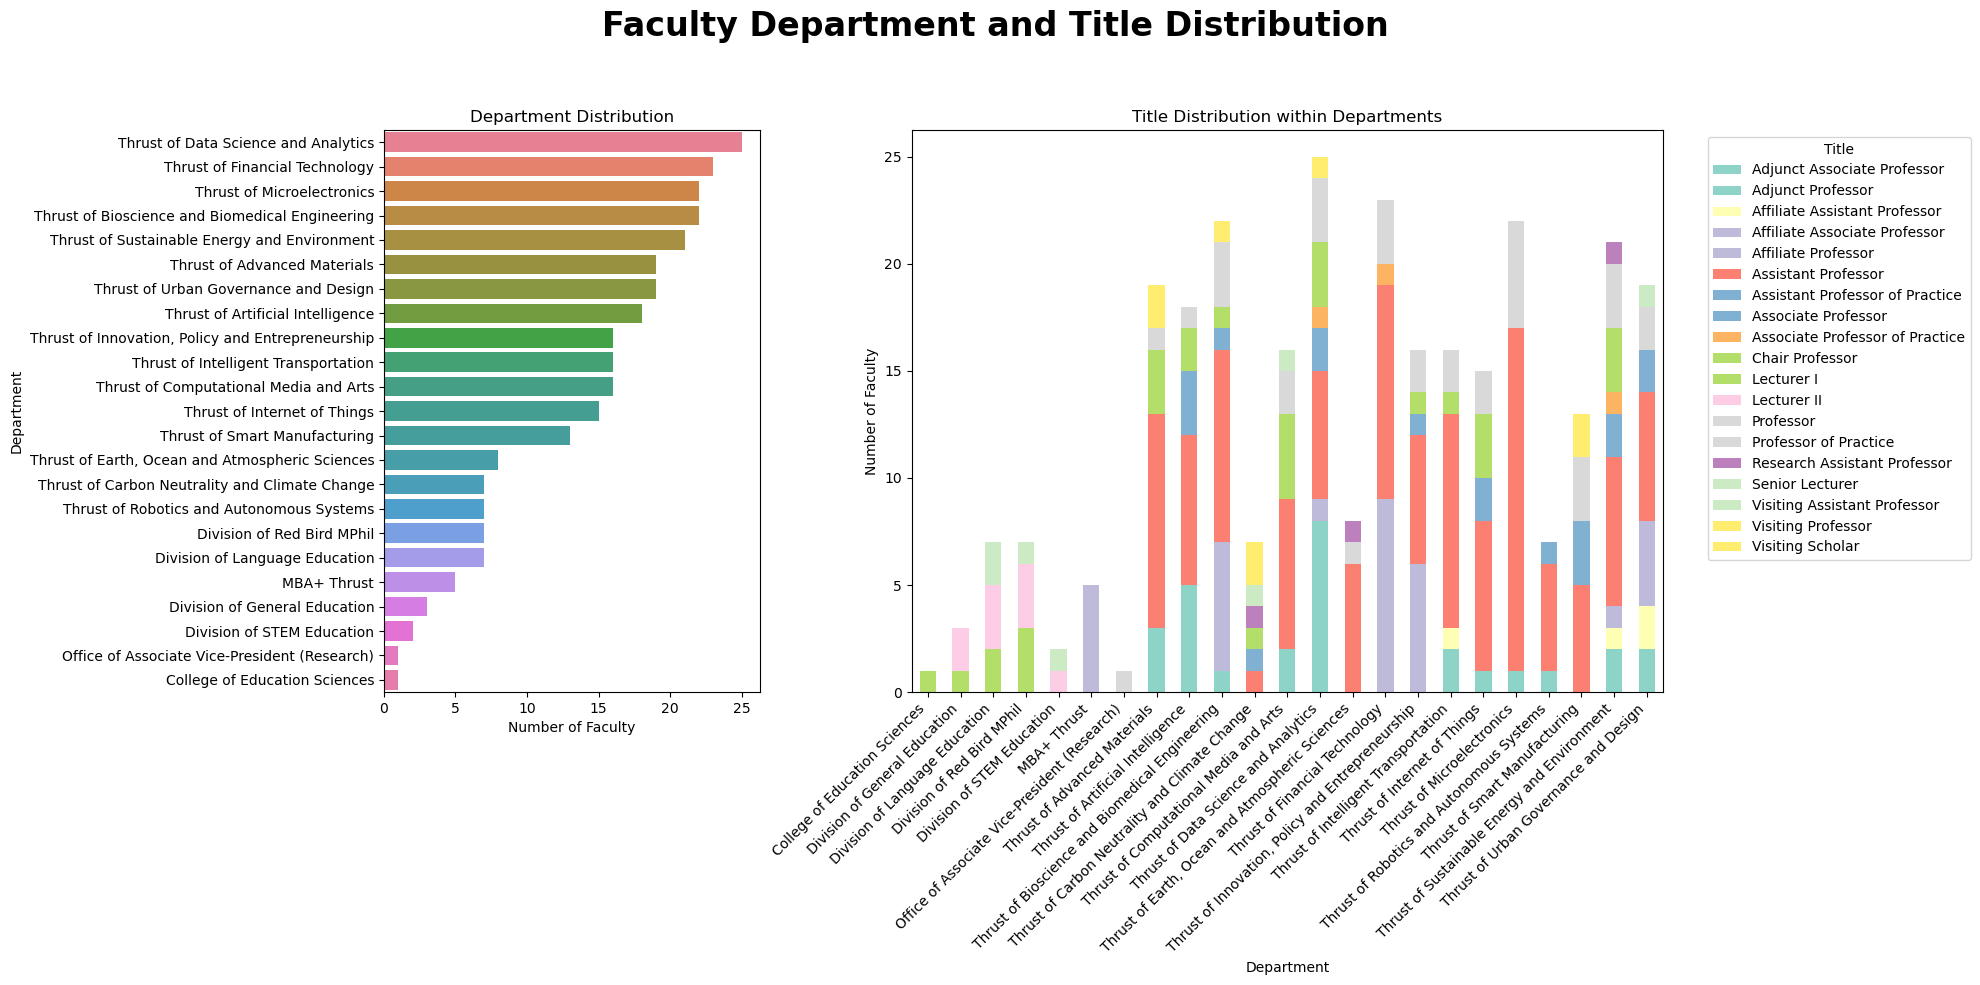

In [19]:
import re

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud


def load_data():
    """
    Load CSV files into pandas dataframes.
    """
    faculty_table = pd.read_csv('faculty_table.csv')
    faculty_grad_year = pd.read_csv('faculty_grad_year.csv')
    return faculty_table, faculty_grad_year


def basic_eda(df):
    """
    Display basic statistics and information of the given dataframe.
    """
    print(df.info())
    print(df.describe())


def plot_faculty_titles_distribution(df):
    """
    Plot a combined chart showcasing faculty titles distribution.
    Left: Horizontal bar chart.
    Right: Donut chart.
    :param df: Input dataframe.
    """
    title_counts = df['Title'].value_counts()

    # Define grid specs and create the figure
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])
    fig = plt.figure(figsize=(18, 9))

    ax1 = plt.subplot(gs[0])  # Bar chart
    ax2 = plt.subplot(gs[1])  # Donut chart

    # --- Bar Chart ---
    sns.barplot(y=title_counts.index, x=title_counts.values, palette="viridis", ax=ax1)
    ax1.set_title('Faculty Titles Count')
    ax1.set_xlabel('Number of Faculty')
    ax1.set_ylabel('Title')

    # --- Donut Chart ---
    colors = sns.color_palette('pastel', len(title_counts))
    wedges, texts, autotexts = ax2.pie(title_counts,
                                       autopct='',
                                       startangle=140,
                                       wedgeprops=dict(width=0.3),
                                       textprops=dict(color="black"),
                                       colors=colors)

    # Draw a circle in the center for 'donut' style
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    # Add percentage labels outside the donut
    for i, (wedge, percentage) in enumerate(zip(wedges, title_counts / title_counts.sum() * 100)):
        ang = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kwargs = dict(xycoords="data", textcoords="data", arrowprops=dict(arrowstyle="-", color="0.5",
                                                                          connectionstyle=connectionstyle), fontsize=10,
                      ha=horizontalalignment)
        ax2.annotate(f"{percentage:.1f}%", xy=(x, y), xytext=(1.7 * np.sign(x), 2 * y), **kwargs)

    # Beautify
    ax2.legend(title_counts.index, title='Titles', loc='upper left', bbox_to_anchor=(1.3, 0.9))
    ax2.set_title('Faculty Titles Percentage')

    fig.suptitle('Faculty Titles Distribution', fontsize=24, fontweight='bold')
    plt.tight_layout()

    plt.show()


def clean_research_interests_data(df):
    """
     Helper function to clean research interests data.
    """

    def clean_interests(interest):
        # Removing characters like [, ], ', "
        cleaned = re.sub(r"[\'\"\[\]]", "", interest)

        # Taking only the main interest before phrases like "e.g."
        main_interest = cleaned.split(", e.g.")[0].strip()
        return main_interest.lower()  # Convert to lowercase

    # Splitting, cleaning and counting research interests
    research_interests = df['Research Interest'].str.split(',').explode().apply(clean_interests).str.strip()

    # Filtering out empty strings, NaN values, and strings like "e.g."
    valid_interests = research_interests[
        research_interests.notna() & (research_interests != '') & (~research_interests.str.contains("^e\.g\.$"))]

    return valid_interests


def plot_research_interests_distribution(df):
    """
    Plot an enhanced combined chart showcasing the top research interests.
    Includes a bar chart for the top 10 interests, a pie chart for the top 6, and a word cloud for all interests.
    """
    # Preparing data
    all_interests = clean_research_interests_data(df).tolist()
    interests_df = pd.DataFrame(all_interests, columns=['Interest'])
    research_counts = interests_df['Interest'].value_counts()

    # Top 10 for bar chart
    top_10_interests = research_counts.head(10)

    # Top 6 for pie chart
    top_6_interests = research_counts.head(6)

    # Set up the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Bar chart with enhanced colors
    color_palette = sns.color_palette("husl", 10)  # Using a vibrant color palette
    sns.barplot(y=top_10_interests.index, x=top_10_interests.values, ax=ax1, palette=color_palette)
    ax1.set_title('Top 10 Research Interests')
    ax1.set_xlabel('Number of Mentions')
    ax1.set_ylabel('Research Interest')

    # Pie chart with shadow and explosion effect
    explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
    wedges, texts, autotexts = ax2.pie(top_6_interests,
                                       labels=top_6_interests.index,
                                       startangle=140,
                                       colors=sns.color_palette('pastel', 6),
                                       explode=explode,
                                       shadow=True,
                                       autopct='',
                                       pctdistance=0.85)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kwargs = dict(xycoords="data", textcoords="data", arrowprops=dict(arrowstyle="-", color="0.5",
                                                                          connectionstyle=connectionstyle), fontsize=10,
                      ha=horizontalalignment)
        ax2.annotate(f"{top_6_interests[i] / sum(top_6_interests) * 100:.1f}%", xy=(x, y),
                     xytext=(1.2 * np.sign(x), 1.4 * y), **kwargs)
    ax2.set_title('Top 6 Research Interests Distribution')

    plt.tight_layout()
    fig.subplots_adjust(top=0.82)
    fig.suptitle('Faculty Research Interests Distribution', fontsize=24, fontweight='bold')

    plt.show()


def plot_faculty_ages_distribution(df):
    """
    Plot histograms of graduate years and estimated ages side by side.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    # Plotting Graduate Year
    sns.histplot(df['Graduate Year'].dropna(), bins=30, kde=False, color="skyblue", ax=axes[0])
    axes[0].set_title('Timeline of Faculty Graduate Years')
    axes[0].set_xlabel('Graduate Year')
    axes[0].set_ylabel('Number of Faculty')

    # Plotting Estimated Age
    sns.histplot(df['Estimated age'].dropna(), bins=30, kde=True, color="dodgerblue", ax=axes[1])
    axes[1].axvline(df['Estimated age'].mean(), color='k', linestyle='--')
    axes[1].axvline(df['Estimated age'].median(), color='r', linestyle='-')
    axes[1].legend({'KDE': "dodgerblue", 'Mean Age': 'k--', 'Median Age': 'r-'})
    axes[1].set_title('Distribution of Faculty Estimated Ages')
    axes[1].set_xlabel('Estimated Age')
    axes[1].set_ylabel('Number of Faculty')

    plt.tight_layout()
    fig.subplots_adjust(top=0.82)
    fig.suptitle('Faculty Ages Distribution', fontsize=24, fontweight='bold')

    plt.show()


def plot_faculty_department_and_title_distribution(df):
    """
    Plot a combined chart showcasing department distribution and title distribution within departments.
    Left: Horizontal bar chart of department distribution.
    Right: Grouped bar chart of title distribution within departments.
    """
    department_counts = df['Thrust/Department/Division'].value_counts()
    data_agg = df.groupby(['Thrust/Department/Division', 'Title']).size().reset_index(name='Counts')
    data_pivot = data_agg.pivot(index='Thrust/Department/Division', columns='Title', values='Counts').fillna(0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 2]})

    # --- Bar Chart for Department Distribution ---
    color_palette = sns.color_palette("husl", len(department_counts))
    sns.barplot(y=department_counts.index, x=department_counts.values, palette=color_palette, ax=ax1)
    ax1.set_title('Department Distribution')
    ax1.set_xlabel('Number of Faculty')
    ax1.set_ylabel('Department')

    # --- Grouped Bar Chart for Title Distribution within Departments ---
    data_pivot.plot(kind='bar', stacked=True, ax=ax2, colormap="Set3")
    ax2.set_title('Title Distribution within Departments')
    ax2.set_ylabel('Number of Faculty')
    ax2.set_xlabel('Department')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Adjusting legend
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, title='Title', loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    fig.subplots_adjust(top=0.86)
    fig.suptitle('Faculty Department and Title Distribution', fontsize=24, fontweight='bold')

    plt.show()


def plot_faculty_overview_word_cloud(df):
    """
    Plot combined word clouds showcasing common words in faculty research interests and overviews.
    """
    # Preparing data for research interests word cloud
    all_interests = clean_research_interests_data(df).tolist()
    interests_df = pd.DataFrame(all_interests, columns=['Interest'])
    research_counts = interests_df['Interest'].value_counts()

    # Generating research interests word cloud
    research_wordcloud = WordCloud(width=450,
                                   height=450,
                                   background_color='white',
                                   colormap="plasma",
                                   max_words=200,
                                   contour_width=3,
                                   contour_color='plasma').generate_from_frequencies(research_counts)

    # Preparing data for faculty overviews word cloud
    overview_text = ' '.join(df['Overview'].dropna())

    # Generating faculty overviews word cloud
    overview_wordcloud = WordCloud(background_color='white', width=450, height=450, max_words=100,
                                   colormap="viridis").generate(overview_text)

    # Setting up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    ax1.imshow(research_wordcloud, interpolation='bilinear')
    ax1.axis('off')
    ax1.set_title('Research Interests')

    ax2.imshow(overview_wordcloud, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title('Faculty Overviews')

    plt.suptitle('Word Clouds for Research Interests & Faculty Overviews', fontsize=24, fontweight='bold', y=1.05)
    plt.tight_layout()
    fig.subplots_adjust(top=0.86)
    fig.suptitle('Faculty Overview WordCloud', fontsize=24, fontweight='bold')

    plt.show()


faculty_table, faculty_grad_year = load_data()
# visualizations
plot_faculty_overview_word_cloud(faculty_table)
plot_faculty_titles_distribution(faculty_table)
plot_research_interests_distribution(faculty_table)
plot_faculty_ages_distribution(faculty_grad_year)
plot_faculty_department_and_title_distribution(faculty_table)

These visualizations provide valuable insights into the distribution of faculty titles, research interests, ages, department and title distribution, and the frequency of keywords in research interests and personal overviews. These analyses and visualizations aid researchers and decision-makers in understanding the characteristics and research directions of the faculty members.